# Project 3 - Big Data Transformation




Bowen Chen

January 30, 2018

## Executive Summary

In this project, the creation of a giant annual return dataset is performed. There is not much of calculation to be done in this project, but the scale and complexity of this dataset is the main challenge. The raw data file contains **daily return data for all stocks from 1926 to 2016** - a total of **90,628,391 rows** that consumes **4.335 GB** in total space. The data is also in a very messy format, with missing data and non-sensible data in numerical columns. After the cleaning activities performed in this project, the total number of rows are reduced to **386,656 rows** -  around 30 times smaller than the oringinal size. The missing data are also filled in as the appropriate values for further analysis.  

## Objectives

Create a annual return dataset that could be more useful for further analysis, without dropping out any rows that contains a bad format of data

## Computations

In [29]:
# R Setup
options(repr.plot.width= 6, repr.plot.height=4, warn = -1)

library(data.table)
library(lubridate)
library(dplyr)
library(ggplot2)


**Import Data**

The data consists of daily returns for all stocks from 1926-1-1 to 2016-12-31, since the size of the file is huge, the use of data.table packages are very important here. The data contains the following fields,


* *PERMNO* - The unique stock identifier
* *date* - The date, in daily frequency
* *TICKER* - The corresponding ticker that the stock used in Exchange
* *CUSIP* - The stock's identifier
* *PRC* - The stock daily price
* *RET* - The stock's daily holding period return after distribution adjustments
* *SHROUT* - Number of shares outstanding



In [4]:
StockReturns_1926_1972 = fread("data//daily_return_26_72.csv")
StockReturns_1973_2016 = fread("data//daily_return_73_16.csv")

Read 14883379 rows and 7 (of 7) columns from 0.679 GB file in 00:00:19
Read 75745012 rows and 7 (of 7) columns from 3.656 GB file in 00:01:28


Some summary statistics of these two datasets

| Dataset Name | Total Rows | File Size   |
|--------------|------------|-------------|
| *Daily Return (1926 - 1972)* | 14883379 | 0.679 GB |
| *Daily Return (1973 - 2016)* | 75745012 | 3.656 GB |
| **Total**| **90628391** | **4.335 GB**|
The dataset will takes around 2 minutes to load

**Convert date to the correct format**

In [5]:
StockReturns_1926_1972[,  `:=` (date = as.Date(as.character(date), 
                                   format = '%Y%m%d', 
                                   origin = "1910-10-01"))]

In [6]:
StockReturns_1973_2016[,  `:=` (date = as.Date(as.character(date), 
                                   format = '%Y%m%d', 
                                   origin = "1910-10-01"))]

**Return Column Data Cleaning**

There are some return datas are blank and some are return as letters B, C or blank, these should all be set to 0. Converting the column to numeric does the job

In [7]:
StockReturns_1926_1972[, RET := as.numeric(RET)] 
StockReturns_1973_2016[, RET := as.numeric(RET)]

Now make all "NA" values in RET column 0

In [8]:
StockReturns_1926_1972[is.na(RET), "RET" := 0]
StockReturns_1973_2016[is.na(RET), "RET" := 0]

After the cleaning of the RET column is performed, there should be no abnormal values other than numeric values 

**Price Column Data Cleaning**

The price column contains negative values. The documentation of the data field noted that 

* Prc is the closing price or the negative bid/ask average for a trading day.


* If the closing price is not available on any given trading day, the number in the price field has a negative sign to indicate that it is a bid/ask average and not an actual closing price. 


* If neither closing price nor bid/ask average is available on a date, prc is set to zero.

We assume that the *bid/ask average* could be treated as the stock price, therefore the negative values are all taken the absolute value

In [9]:
StockReturns_1926_1972[, PRC:= abs(PRC)]
StockReturns_1973_2016[, PRC:= abs(PRC)]

When the stock disappears, the price and number of shares outstanding are all showing NAs while Returns are 0 (as previously imputed). Use the same trick, set the NA *PRCs* and *SHROUTs* to 0

In [10]:
StockReturns_1926_1972[is.na(PRC), "PRC" := 0]
StockReturns_1926_1972[is.na(SHROUT), "SHROUT" := 0]
StockReturns_1973_2016[is.na(PRC), "PRC" := 0]
StockReturns_1973_2016[is.na(SHROUT), "SHROUT" := 0]

After the removal of the companies that has all 0s across the columns, check the top 5 rows of the data.table *StockReturns_1973_2016*

In [11]:
StockReturns_1973_2016[1:5,]

PERMNO,date,TICKER,CUSIP,PRC,RET,SHROUT
10000,1986-01-06,,68391610,0.0000,0.00000,0
10000,1986-01-07,OMFGA,68391610,2.5625,0.00000,3680
10000,1986-01-08,OMFGA,68391610,2.5000,-0.02439,3680
10000,1986-01-09,OMFGA,68391610,2.5000,0.00000,3680
10000,1986-01-10,OMFGA,68391610,2.5000,0.00000,3680


** Annual Geometric Return and Market Cap**

The annual geometric return could be found by 

$$ r_{geometric} = [(1 + r_1)(1 + r_2)\cdots(1 + r_{n_{months}})] ^{\frac{1}{n_{months}}} - 1$$

The aggregation could be accomlished the *group_by* command in R 

Two assumptions are made:

* If the company changes its ticker or CUSIP during the year, use the value of the last day of the year

* The stock price and shares outstanding are chosen as the value of the last day of the year to calculate market cap

Note: since the data.tables used in the calculation are huge, the original table needs to be removed to free up space to allow further calculations

In [12]:
StockAnnual_1926_1972 = StockReturns_1926_1972 %>% 
                                    group_by( PERMNO,
                                              year= ceiling_date(date, "year") - 1) %>% 

                                    summarise(TICKER = last(TICKER),
                                              CUSIP = last(CUSIP),
                                              `Market Cap` = last(PRC) * last(SHROUT),
                                              `Annual Return` = (function(r) prod(1 + r))(RET)) %>% as.data.table() 

In [13]:
rm(StockReturns_1926_1972)

In [14]:
StockAnnual_1973_2016 = StockReturns_1973_2016 %>% 
                                    group_by( PERMNO,
                                              year= ceiling_date(date, "year") - 1) %>% 

                                    summarise(TICKER = last(TICKER),
                                              CUSIP = last(CUSIP),
                                              `Market Cap` = last(PRC) * last(SHROUT),
                                              `Annual Return` = (function(r) prod(1 + r))(RET))%>% as.data.table() 

In [15]:
rm(StockReturns_1973_2016)

**Ajust Return column to percentage terms**

Take every value in *Annual Return* column and subtract 1

In [16]:
StockAnnual_1926_1972[, `Annual Return` :=`Annual Return` - 1]
StockAnnual_1973_2016[, `Annual Return` := `Annual Return` - 1]

Now have a look of the top 5 rows one of the two annual datasets

In [17]:
StockAnnual_1973_2016[1:5,]

PERMNO,year,TICKER,CUSIP,Market Cap,Annual Return
10000,1986-12-31,OMFGA,68391610,1981.566,-0.79878059
10000,1987-12-31,OMFGA,68391610,0.000,-0.57575850
10001,1986-12-31,GFGC,36720410,6937.000,0.29704516
10001,1987-12-31,GFGC,36720410,5828.000,-0.09898353
10001,1988-12-31,GFGC,36720410,6362.250,0.16085603


Two facts confirmed the correct implementation of the data transformation above

1. The market cap will be 0 if the stock decide to exit the market, evident from stock **OMFGA** in 1987
2. The stock does not have tickers back in 1926, but the return and market cap data should all be avaliable

**Union two datasets**

Combine two datasets into one big dataset, sorted by both *PERMNO* and *date*

In [18]:
setkey(StockAnnual_1926_1972, "PERMNO")
setkey(StockAnnual_1973_2016, "PERMNO")

In [19]:
StockAnnual = rbindlist(list(StockAnnual_1926_1972, StockAnnual_1973_2016),
                        use.names= TRUE, fill = TRUE)

Check top 10 rows of the resulting datatable

In [20]:
StockAnnual[1:10,]

PERMNO,year,TICKER,CUSIP,Market Cap,Annual Return
10006,1926-12-31,,00080010,60900,0.008757617
10006,1927-12-31,,00080010,66150,0.150645231
10006,1928-12-31,,00080010,58875,-0.054262619
10006,1929-12-31,,00080010,46800,-0.153685438
10006,1930-12-31,,00080010,16500,-0.598322636
10006,1931-12-31,,00080010,4050,-0.739717117
10006,1932-12-31,,00080010,4200,0.037040870
10006,1933-12-31,,00080010,14700,2.499998585
10006,1934-12-31,,00080010,11100,-0.244895544
10006,1935-12-31,,00080010,20325,0.831088490


**Application: Equal Weighted Portfolio**

One example usage of this dataset is demonstrating the annual return of the equally weighted portfolio. Start with finding the average return of the equal weighted portfolio,

In [31]:
equal_weighted_portfolio = StockAnnual %>% group_by(year) %>% 
                                            summarise(`Annual Return` = mean(`Annual Return`)) %>% 
                                            as.data.table() 

Plot the annual returns of the equal wieghted portfolio

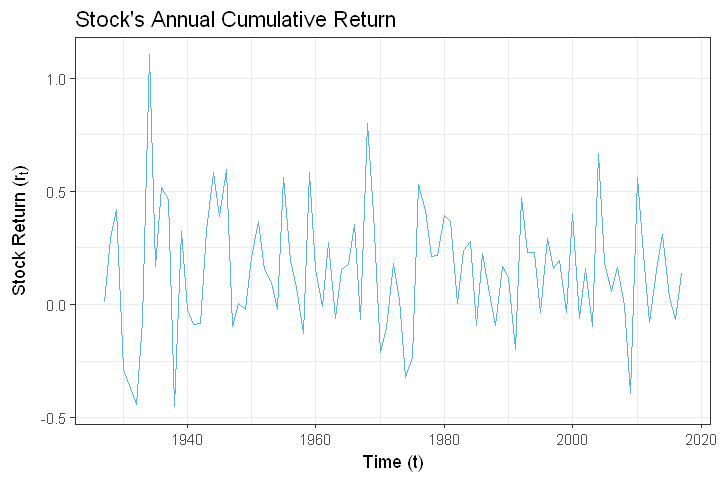

In [32]:
ggplot(data=equal_weighted_portfolio, aes(x=year, y= `Annual Return`, group=1)) +
  theme_bw()+
  geom_line(color="#56B4E9") +
  labs(title = "Stock's Annual Return",
  x = "Time (t)", 
  y = expression(paste("Stock Return (",r[t], ")")),
  parse = TRUE)

### Conclusion

Cleaning up the data seems like a simple task, but it is a very important step. Real world datasets can be really messy, hence not suitable to conduct analysis directly. This project has successfully transformed a huge dataset (around 1 million rows) to a realtively smaller (30x smaller size), which could be crucial for efficiency and computing time needs. The result dataset will be more ready for analysis in the future.